# C: Concrete

There are no hints in this lab sheet. Most of what you need can be found in the Notebooks for lectures 4, 5 and 6. 

You can see answers in the usual way, provided you execute the next cell.

In [1]:
%run do_install_HAs.py C_concrete_lab

To add  some spice to this lab, for those of you who want, we'll make it a competition. Towards the end of the session, we will share solutions to discover whose solution has done best on the test set.

As you work through this lab sheet, you will need to come back and insert more `import` commands into the next code cell.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
rng = np.random.RandomState(2)

## The business problem

In a construction task, we want to choose the right recipe for the concrete - one that delivers concrete of sufficient strength at the right cost. The basic ingredients in conventional concrete are cement, fine and coarse aggregates, and water. High-performance concrete also incorporates materials such as fly ash, blast furnace slag, and superplasticizer. The exact recipe is difficult to state. Therefore, it would be useful to be able to predict the strength of the concrete produced by a particular recipe.

## Performance measures

**Exercise 1.** - Is this regression or classification?
- What performance metric will you use?
- What will you compare against to know whether you have succeeded?

## Dataset

The dataset you will use is in the file called `concrete.csv`. The original was collected by I.-C. Yeh and described in the following paper: 
[I.-C. Yeh: Modeling of strength of high-performance concrete using artificial neural networks, Cement and Concrete Research,
vol.28(12), 1998, pp.1797-1808](https://doi.org/10.1016/S0008-8846(98)00165-3).
A copy of the dataset is now publicly-available in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/): [Concrete Compressive Strength](https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength)

In [6]:
import os
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
    base_dir = "."
dataset_dir = os.path.join(base_dir, "datasets")

In [7]:
df = pd.read_csv(os.path.join(dataset_dir, "concrete.csv"))

## Take a cheeky look

**Exercise 2.** Write some code cells to inspect the dataset.

## Cleanup anything that is simply invalid

Nothing to do here! This is a very clean dataset: numeric-valued features only; no missing values; no outliers.

## Split into training set and test set

**Exercise 3.** Split the dataset into `X_train`, `X_test`, `y_train` and `y_test`. (Watch out: a classic error is to include the target as one of the features.)

##  Exploratory Data Analysis

**Exercise 4.** On a copy of the training set, produce a set of scatter plots - of every column with every column.

**Exercise 5.** On your copy of the training set, compute the Pearson correlation coefficient of every column with every other column.

Don't just create the scatter plots and the correlations! Look at them! Which features seem important? Do any look to be redundant?

## Feature Engineering

This is the step where I want you to spend some time. The idea is to create new features from the existing features - ones that you think may be predictive of concrete strength. They can be sums, products, ratios of existing features. You can square features or apply functions such as log and sqrt,...

Use what you learned from the EDA to guide you.

Ideally, you need a domain expert to help you. In the absence of a domain expert, you might use (a) your intelligence, (b) the web, or (c) a GenAI chatbot.

Insert your new features into the copy of the training data. And once you've done that, re-compute the Pearson correlation coefficients. 

I will show you one example. You should try several more of your own. (My example assumes that `train_copy` is the name of the variable that references the copy of the training set.)

In [16]:
# The ratio of cement to water. (water will never be zero, hence I won't get a div-by-zeror error.)
train_copy["cement_to_water"] = train_copy["cement"] / train_copy["water"]

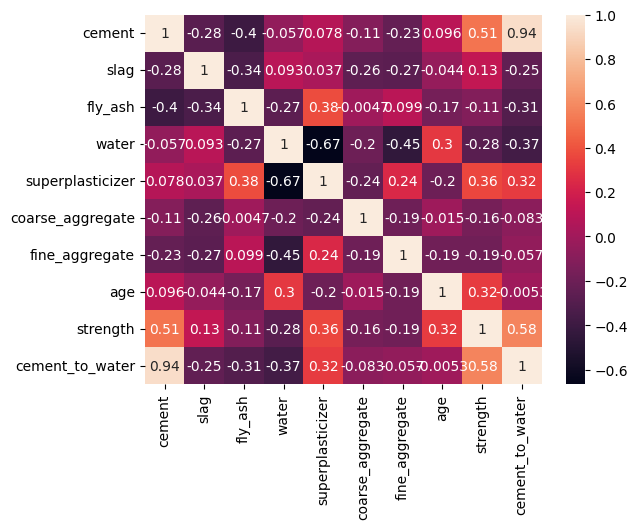

In [17]:
sns.heatmap(train_copy.corr(numeric_only=True), annot=True)
plt.show()

My new feature is only modestly predictive of `strength` (30.58) and highly correlated with `cement` (0.94). This would motivate me to modify the new feature in order to improve it, or to consider other new features.

## Preprocess the Data

From now on, we work on the original data, not the copy.

We have no outliers, no missing values, no non-numeric features. We do need to scale if we later use kNN - but we'll do that as part of the grid search. 

So the only thing for you to do now is to define a class to insert each new feature that you devised during Feature Engineering - or, maybe not every feature, just the promising ones.

Mine wasn't very promising but I'll write the class anyway.

In [19]:
class InsertCementToWaterRatio(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["cement_to_water"] = X["cement"] / X["water"]
        return X

**Exercise 6.** Write classes to insert your new features.

**Exercise 7.** Now you create the `preprocessor`. All you need is a `Pipeline`. You don't need a `ColumnTransformer` because you only have numeric-valued features.

## Model selection

**Exercise 8.** You must choose your validation method. Which will you choose - holdout or k-fold CV?

**Exercise 9.** Hopefully, when thinking about Performance Measures earlier, you decided you would use a dummy regressor as a baseline against which to compare. So, create that dummy regressor, fit it and evaluate it.

Now, here's my function that helps you do Model Selection:

In [28]:
def grid_search(preprocessor, predictor, param_grid, cv, metric, X_train, y_train):
    model = Pipeline([
                ("preprocessor", preprocessor),
                ("predictor", predictor)
    ])

    gs = GridSearchCV(model, param_grid, scoring=metric, cv=cv, n_jobs=-1)

    gs.fit(X_train, y_train)

    return gs

**Exercise 10.** Use my function to do Model Selection on kNN.

**Exercise 11.** Now do the same for Decision Trees.

Are Decision Trees and kNN better than the dummy? Which is better: kNN or Decision Trees? Does the difference look to be significant?

Now, you can iterate! Go back to an earlier step and make improvements. For example, Decision Trees can quantify the importance of each feature (features that occur a lot or near the root are more important). This might give you new ideas for Feature Engineering.

The code to get the feature importances is simple: if `decision_tree` contains a fitted Decison Tree, then we need `decision_tree.feature_importances_`. Unfortunately, our Decision Tree is not in a nice variable called `decision_tree`. It is the `predictor` step of a pipeline in the `best_estimator_` found by our grid search. So, assuming your Decision Tree grid search is in a variable called `decision_tree_gs`, you could write the following:

In [31]:
decision_tree = decision_tree_gs.best_estimator_.named_steps["predictor"]
feature_importances = decision_tree.feature_importances_
sorted(list(zip(features + ["cement_to_water"], feature_importances)), key = lambda x: (x[1],x[0]), reverse=True)

[('age', np.float64(0.24811980576960208)),
 ('cement_to_water', np.float64(0.07593233447500089)),
 ('coarse_aggregate', np.float64(0.02398739162833671)),
 ('fly_ash', np.float64(0.018363986222207782)),
 ('cement', np.float64(0.018178941040075083)),
 ('fine_aggregate', np.float64(0.00854125254779877)),
 ('superplasticizer', np.float64(0.0076122219412785045)),
 ('water', np.float64(0.006116556275513233)),
 ('slag', np.float64(0.003061468067403856))]

Interestingly, you;ll see that my unpromisng new feature (`cement_to_water`) is the most important - which goes to show that you shouldn't rely too much on Pearson correlation coefficients! How did your new features fare?

Now, go back and try some more feature engineering.

## Error Estimation - evaluate on the the test set

**Exercise 12.** Only move on to this step when you are certain you've finished with Model Selection. 

Evaluate your winning model on the test set.